In [1]:
import os
import re
import requests
import zipfile
import plotly.express as px
from matplotlib import pyplot as plt

import nltk


from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from typing import Callable

%matplotlib inline

In [2]:
nltk.download("popular")

[nltk_data] Error loading popular: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

# Introduction

The goal of this notebook is to *practice text preprocessing*


You're part of a team in Twitter that's assigned to create a sentiment analysis model for tweets in Arabic, your task is to prepare the data for training a model to classify wether the tweet has *positive* or *negative* sentiment

## Components of Preprocessing

### Text Cleaning

We need to remove or keep parts of the tweet so that the remaining text is **relevant** to the task at hand 

#### What are the possbile parts to remove or keep?

1. Hashtags
2. Mentions
3. Emojis
4. URLs
5. Numbers
6. English characters
7. Stop words
8. Diactrics
9. Punctiation marks
10. Others

### Stemming / Lemmatisation



### Steps
In this notebook we should:

1. Read the raw data
2. Explore the dataset
3. Text Cleaning
4. Stemming / Lemmatisation

## The Dataset

The dataset for this project is ArSenTD-Lev, a collection of 4,000 labeled tweets in the Levantine dialect, along side the tweet text:

- Country
- Topic (personal, politics, religion, sports, entertainment, others)
- Sentiment (very_negative, negative, neutral, positive, very_positive)
- Sentiment_Expression : implicit, explicit, or none (when neutral)
- Sentiment_Target: The part of the text of which the sentiment was derived

The original dataset is found on the [original website](http://oma-project.com/ArSenL/ArSenTD_Lev_Intro)

and with another copy of the dataset found on the [course website](https://shai-nlp-course.netlify.app/ArSenTD-LEV.tsv)

# Setup

In [3]:
data_dir = os.path.join(os.curdir, "data")
archive_path = os.path.join(data_dir, "ArSenTD-LEV.zip")
tweets_dir = os.path.join(data_dir, "ArSenTD-LEV")

## Download Raw Data



In [4]:
link = "http://oma-project.com/ArSenL/ArSenTD-LEV.zip"

response = requests.get(link)

with open(archive_path, "wb+") as f:
    f.write(response.content)
    
with zipfile.ZipFile(archive_path, 'r') as zip_f:
    zip_f.extractall(tweets_dir)


os.listdir(tweets_dir)

['ArSenTD-LEV.tsv', 'README.txt']

In [5]:
raw_filepath = os.path.join(tweets_dir, "ArSenTD-LEV.tsv")

In [6]:
raw = pd.read_csv(filepath_or_buffer=raw_filepath, sep="\t", encoding="utf_8")

In [7]:
raw.head()

Tweet    Country     Topic  \
0  "ÿ£ŸÜÿß ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿπŸÜÿØ ÿßÿ®ÿ™ÿπÿßÿØ ŸÖ...    lebanon  personal   
1  ŸÖŸÜ ÿßŸÑÿ∞ÿßŸÉÿ±Ÿá... @3FInQe . ÿπŸÜÿØŸÖÿß ÿßÿπÿ™ŸÇÿØ ŸÉÿ±Ÿäÿ≥ÿ™ŸäÿßŸÜŸà ...     jordan    sports   
2  ŸÑÿß ŸÜÿÆŸÑŸà ŸÖŸÜ ÿ∂ÿ∫Ÿàÿ∑ÿßÿ™ ÿßŸÑÿ≠Ÿäÿßÿ©. ŸÅŸÜÿ≠ŸÜ ŸÜÿπŸäÿ¥ ÿπŸÑŸâ ÿ£ÿ±ÿ∂ ÿ£ÿπ...  palestine  personal   
3  #ŸÖÿµÿ∑ŸÑÿ≠ÿßÿ™_ŸÑÿ®ŸÜÿßŸÜŸäŸá_ÿ≠Ÿäÿ±ÿ™_ÿßŸÑÿ®ÿ¥ÿ±ŸäŸá ÿ®ÿ™ŸàÿµŸÑ ÿπÿßŸÑÿ®Ÿäÿ™ ÿå ÿ®...    lebanon  personal   
4  ŸÜÿµŸÖÿ™ !! ŸÑÿ™ÿ≥Ÿäÿ± ÿ≠Ÿäÿßÿ™ŸÜÿß ÿπŸÑŸâ ŸÖŸã Ÿäÿ±ÿßŸÖ ŸÅÿßŸÑŸÜÿßŸëÿ≥ ŸÑŸÖ ÿ™ÿπ...  palestine  personal   

  Sentiment Sentiment_Expression     Sentiment_Target  
0  negative             implicit          ÿ®ÿ±ŸäŸÇ ÿßŸÑÿπŸäŸàŸÜ  
1  positive             explicit  ÿßŸÅÿ∂ŸÑ ŸÑÿßÿπÿ® ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ  
2   neutral                 none                 none  
3  negative             explicit      ŸÖÿµÿ∑ŸÑÿ≠ÿßÿ™_ŸÑÿ®ŸÜÿßŸÜŸäŸá  
4  negative             explicit       ÿ≥ ŸÑŸÖ ÿ™ÿπÿØ ŸÉŸÖÿß ŸÉ

# Explaratory Data Analysis (EDA)

In [8]:
data = raw.copy(deep=True)

In [9]:
data["Sentiment"] = data["Sentiment"].replace(
    {"very_negative": "negative", "very_positive": "positive"}
)

In [10]:
px.pie(data,names='Sentiment')

### Common EDA Patterns Text

- Check for word count
- Check for character count

In [11]:
# Count words for each tweet
data["word_count"] = data["Tweet"].apply(lambda x: len(x.split(" ")))

In [12]:
data["word_count"].describe()

count    4000.00000
mean       22.69825
std         3.28495
min         7.00000
25%        21.00000
50%        23.00000
75%        25.00000
max        35.00000
Name: word_count, dtype: float64

In [13]:
# Count nums of chrc for each tweet
data["char_count"] = data["Tweet"].apply(len)
data["char_count"].describe()

count    4000.000000
mean      131.364250
std        14.314636
min        42.000000
25%       128.000000
50%       138.000000
75%       140.000000
max       147.000000
Name: char_count, dtype: float64

In [14]:
px.histogram(data, x="word_count",title='word_count',color_discrete_sequence=['indianred'] )


In [15]:
px.histogram(data, x="char_count",title='char_count',color_discrete_sequence=['aquamarine'] )


## Vocabulary

Vocabulary: the set of unique vocabulary in the corpus
and optionally the count of each vocab

In [16]:
all_words = [word for tweet in data["Tweet"] for word in tweet.split(" ")]

In [17]:
vocab = Counter(all_words)

Explore the most and least common words in the vocab

In [18]:
print("Least Common")
vocab.most_common()[-10:]

Least Common


[('ÿßŸÑÿ±Ÿäÿ≠ÿ©', 1),
 ('ŸÜŸÇŸÑÿßŸã', 1),
 ('ŸÖÿ®ÿßÿ¥ÿ±ÿßŸã', 1),
 ('ŸÜÿ¥ÿ±ÿ©', 1),
 ('ÿßŸÑÿ±Ÿäÿßÿ∂Ÿäÿ©', 1),
 ('8:30', 1),
 ('"ÿßŸÑÿπÿ±ÿ®"', 1),
 ('ÿ≠ŸÖŸàÿØ', 1),
 ('üìç', 1),
 ('https://t.co/oUstA9G7dM', 1)]

In [19]:
print("Most Common")
vocab.most_common(n=10)

Most Common


[('ŸÖŸÜ', 1906),
 ('ŸÅŸä', 1610),
 ('.', 1105),
 ('Ÿà', 963),
 ('ÿπŸÑŸâ', 913),
 ('ÿßŸÑŸÑŸá', 787),
 ('ŸÖÿß', 769),
 ('ŸÑÿß', 656),
 ('ÿå', 589),
 ('ŸÉŸÑ', 493)]

In [20]:
counts = list(vocab.values())

In [21]:
data['temp_list'] = data['Tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(90))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')


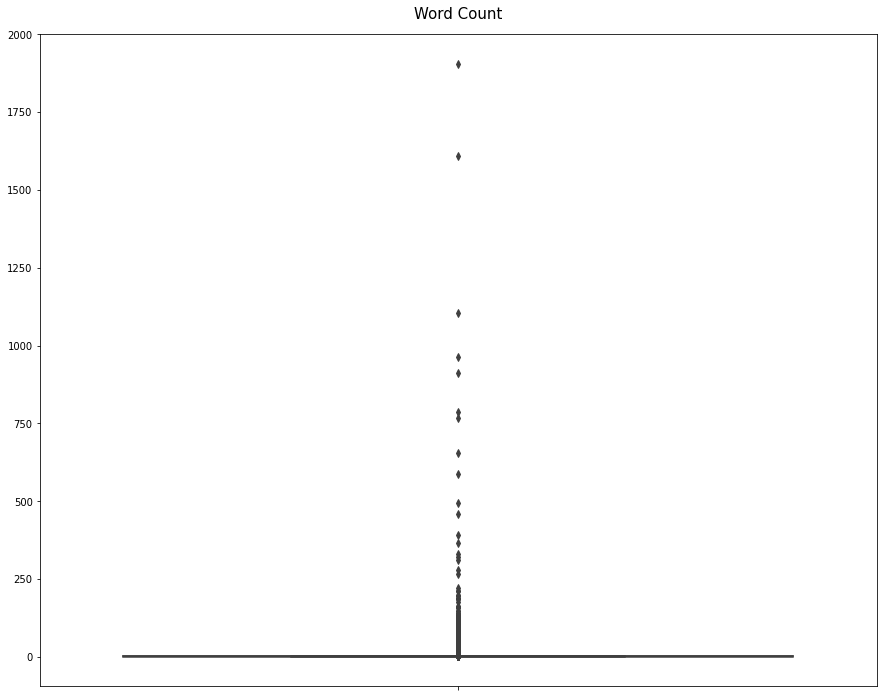

In [22]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

In [23]:
fig = px.bar(temp[:20], x='Common_words', y='count', title='Counts of top unigram before removing stop words', template='plotly_white', labels={'ngram': 'unigrams', 'count': 'Count'})
fig.show()

In [24]:
stop_words = stopwords.words("arabic")
all_words_pruned = [word for tweet in data["Tweet"] for word in tweet.split(" ") if word not in stop_words]

In [25]:
pruned_vocab = Counter(all_words_pruned) 

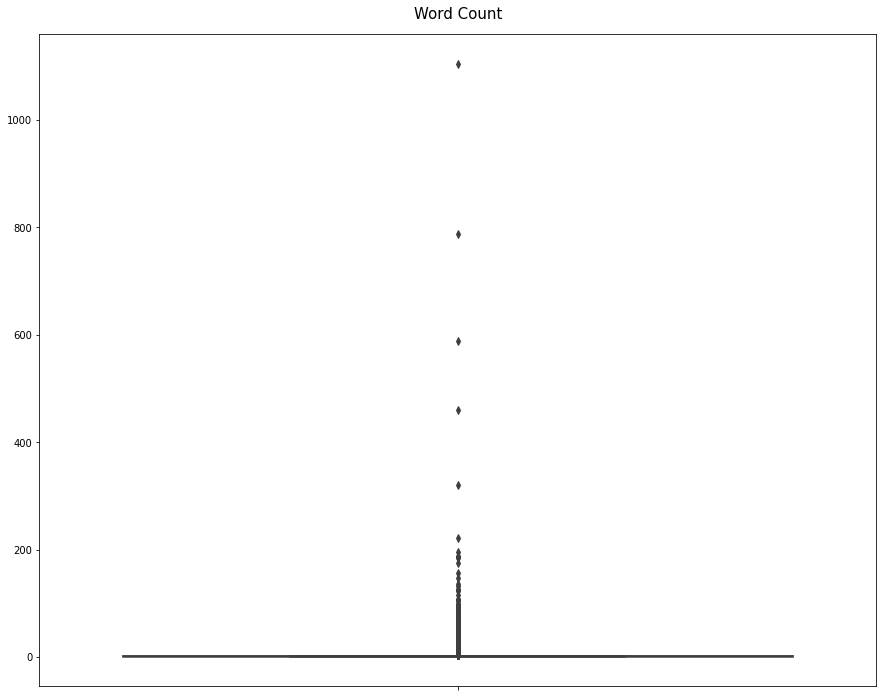

In [26]:
counts = list(pruned_vocab.values())

fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

> Removing stop words still produces a box plot with this many outliers indicates that more cleaning is necessary

# Text Cleaning

let's take sample frome data to check our cleaning

In [27]:
sample = data.iloc[102]["Tweet"]
sample

'ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA'

In [28]:
def test_clean_fn(fn: Callable, sample: str) -> str:
    print(sample, fn(sample), sep="\n")

## Stop Words

In [29]:
stop_words

['ÿ•ÿ∞',
 'ÿ•ÿ∞ÿß',
 'ÿ•ÿ∞ŸÖÿß',
 'ÿ•ÿ∞ŸÜ',
 'ÿ£ŸÅ',
 'ÿ£ŸÇŸÑ',
 'ÿ£ŸÉÿ´ÿ±',
 'ÿ£ŸÑÿß',
 'ÿ•ŸÑÿß',
 'ÿßŸÑÿ™Ÿä',
 'ÿßŸÑÿ∞Ÿä',
 'ÿßŸÑÿ∞ŸäŸÜ',
 'ÿßŸÑŸÑÿßÿ™Ÿä',
 'ÿßŸÑŸÑÿßÿ¶Ÿä',
 'ÿßŸÑŸÑÿ™ÿßŸÜ',
 'ÿßŸÑŸÑÿ™Ÿäÿß',
 'ÿßŸÑŸÑÿ™ŸäŸÜ',
 'ÿßŸÑŸÑÿ∞ÿßŸÜ',
 'ÿßŸÑŸÑÿ∞ŸäŸÜ',
 'ÿßŸÑŸÑŸàÿßÿ™Ÿä',
 'ÿ•ŸÑŸâ',
 'ÿ•ŸÑŸäŸÉ',
 'ÿ•ŸÑŸäŸÉŸÖ',
 'ÿ•ŸÑŸäŸÉŸÖÿß',
 'ÿ•ŸÑŸäŸÉŸÜ',
 'ÿ£ŸÖ',
 'ÿ£ŸÖÿß',
 'ÿ£ŸÖÿß',
 'ÿ•ŸÖÿß',
 'ÿ£ŸÜ',
 'ÿ•ŸÜ',
 'ÿ•ŸÜÿß',
 'ÿ£ŸÜÿß',
 'ÿ£ŸÜÿ™',
 'ÿ£ŸÜÿ™ŸÖ',
 'ÿ£ŸÜÿ™ŸÖÿß',
 'ÿ£ŸÜÿ™ŸÜ',
 'ÿ•ŸÜŸÖÿß',
 'ÿ•ŸÜŸá',
 'ÿ£ŸÜŸâ',
 'ÿ£ŸÜŸâ',
 'ÿ¢Ÿá',
 'ÿ¢Ÿáÿß',
 'ÿ£Ÿà',
 'ÿ£ŸàŸÑÿßÿ°',
 'ÿ£ŸàŸÑÿ¶ŸÉ',
 'ÿ£ŸàŸá',
 'ÿ¢Ÿä',
 'ÿ£Ÿä',
 'ÿ£ŸäŸáÿß',
 'ÿ•Ÿä',
 'ÿ£ŸäŸÜ',
 'ÿ£ŸäŸÜ',
 'ÿ£ŸäŸÜŸÖÿß',
 'ÿ•ŸäŸá',
 'ÿ®ÿÆ',
 'ÿ®ÿ≥',
 'ÿ®ÿπÿØ',
 'ÿ®ÿπÿ∂',
 'ÿ®ŸÉ',
 'ÿ®ŸÉŸÖ',
 'ÿ®ŸÉŸÖ',
 'ÿ®ŸÉŸÖÿß',
 'ÿ®ŸÉŸÜ',
 'ÿ®ŸÑ',
 'ÿ®ŸÑŸâ',
 'ÿ®ŸÖÿß',
 'ÿ®ŸÖÿßÿ∞ÿß',
 'ÿ®ŸÖŸÜ',
 'ÿ®ŸÜÿß',
 'ÿ®Ÿá',
 'ÿ®Ÿáÿß',
 'ÿ®ŸáŸÖ',
 'ÿ®ŸáŸÖÿß',
 'ÿ®ŸáŸÜ',
 'ÿ®Ÿä',
 'ÿ®ŸäŸÜ',
 'ÿ®ŸäÿØ',
 'ÿ™ŸÑŸÉ',
 'ÿ™ŸÑŸÉŸÖ',
 'ÿ™ŸÑŸÉŸÖÿß',
 'ÿ™Ÿá',
 'ÿ™Ÿä',
 'ÿ™ŸäŸ

In [30]:
list(temp.Common_words.values[:100])

['ŸÖŸÜ',
 'ŸÅŸä',
 '.',
 'Ÿà',
 'ÿπŸÑŸâ',
 'ÿßŸÑŸÑŸá',
 'ŸÖÿß',
 'ŸÑÿß',
 'ÿå',
 'ŸÉŸÑ',
 '..',
 'ÿπŸÜ',
 'Ÿäÿß',
 'ŸÖÿπ',
 'ÿßŸÜ',
 'ÿ£ŸÜ',
 'ŸàŸÑÿß',
 'ÿ®ÿ≥',
 'ÿßŸÑŸâ',
 'ÿ®ÿπÿØ',
 'ŸáŸà',
 'Ÿáÿ∞ÿß',
 'ÿ®ŸÜ',
 ':',
 'ŸÑÿ®ŸÜÿßŸÜ',
 '-',
 '...',
 'ŸÉÿßŸÜ',
 'ŸÑŸà',
 'ÿßŸÑŸÑŸáŸÖ',
 'ÿ•ŸÑŸâ',
 'ÿßŸà',
 'ÿßŸÑÿ∞Ÿä',
 'ÿßŸÜÿ™',
 'ÿ≠ÿ™Ÿâ',
 'ÿßŸÑÿ™Ÿä',
 'ÿßŸÑŸÑŸä',
 'ÿπ',
 'ÿßŸÜÿß',
 'ŸÖÿ¥',
 'ÿßŸÑÿ≠ÿ±Ÿäÿ±Ÿä',
 'ŸáŸä',
 'ŸÑŸÖ',
 'ŸáŸÑ',
 'ÿßŸÑŸäŸàŸÖ',
 'ÿπŸÑŸäŸá',
 'ÿ£Ÿà',
 'ŸÑŸÉ',
 'ÿßŸÑÿ≥ÿπŸàÿØŸäÿ©',
 'ÿßŸÑŸä',
 'ÿ®ŸäŸÜ',
 'ÿπŸÖ',
 'ŸÇÿ®ŸÑ',
 'ŸÉÿßŸÜÿ™',
 'ŸàÿßŸÑŸÑŸá',
 'ÿ∫Ÿäÿ±',
 'ÿπŸÜÿØŸÖÿß',
 'ÿü',
 'ŸÑŸä',
 '!',
 'Ÿáÿ∞Ÿá',
 'ŸäŸàŸÖ',
 'ŸäŸÉŸàŸÜ',
 'ÿßÿ∞ÿß',
 'ŸÑŸá',
 'ÿ•ŸÑÿß',
 'ŸÇÿßŸÑ',
 'ŸÉŸÜÿ™',
 'ÿ≠ÿ≤ÿ®',
 'ÿßŸÑÿß',
 'ŸÖÿ≠ŸÖÿØ',
 'Ÿàÿßÿ≠ÿØ',
 'ÿ¥Ÿä',
 'ÿ¥Ÿà',
 'ÿ≥ŸÑŸÖÿßŸÜ',
 'ŸÑŸÜ',
 'ÿßŸÑŸÜÿßÿ≥',
 'ÿ£ŸÜÿ™',
 'ÿßŸÜŸà',
 'ŸäÿπŸÜŸä',
 'ÿ≥ÿπÿØ',
 'ÿ•ŸÜ',
 'ŸÉŸäŸÅ',
 'ÿßŸÑÿ±ÿ¶Ÿäÿ≥',
 'ÿßŸÜŸá',
 '"',
 'ŸÇÿØ',
 'ÿ±ÿ¶Ÿäÿ≥',
 'ÿßŸä',
 'ÿßŸÑÿπÿßŸÑŸÖ']

In [64]:
stop_words=stop_words+list(temp.Common_words.values[:100])+['ÿßŸÜ','ÿßŸÑŸâ','ÿßŸà','ÿßŸÜÿ™']

In [65]:
'ÿßŸÜ' in stop_words

True

In [32]:
stop_words= stopwords.words("arabic")+list(temp.Common_words.values[:100])+['ÿßŸÜ','ÿßŸÑŸâ','ÿßŸà','ÿßŸÜÿ™']
to_keep = ["ŸÑÿß","ÿßŸÑÿ≥ÿπŸàÿØŸäÿ©","ÿßŸÑÿ±ÿ¶Ÿäÿ≥","ÿßŸÑÿ≠ÿ±Ÿäÿ±Ÿä","ÿ≥ÿπÿØ","ŸÑÿ®ŸÜÿßŸÜ","ÿßŸÑÿπÿ±ÿßŸÇ","ÿ≥Ÿàÿ±Ÿäÿß","Ÿäÿßÿ±ÿ®"]

stop_words = [word for word in stop_words if word not in to_keep] 

def remove_stop_words(text: str) -> str:
    return " ".join([word for word in text.split(" ") if word not in stop_words])


test_clean_fn(remove_stop_words, sample)

ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA
ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA


## Remove Hashtags

[Regex to remove hashtag](https://regexr.com/3gkpo)

In [33]:
hashtag_re = re.compile(pattern="#[A-z0-9_ÿß-Ÿä]+")

def remove_hashtag(text: str) -> str:
    return hashtag_re.sub(repl="", string=text)

test_clean_fn(remove_hashtag, sample)

ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA
ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ .  . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA


## Remove Mention

In [34]:
def remove_mention(text: str) -> str:
    # TODO: Look for a suitable way to remove mentions from a text
    # TIP: Look for a regex expression
    return re.sub(pattern=r"@[^\s]+", repl="", string=text)
    
test_clean_fn(remove_mention, sample)

ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA
ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT .  ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA


## Remove Punctuation Marks

In [35]:
def remove_punctation(text: str) -> str:
    # TODO: Look for a suitable way to remove punctiation marks from a text
    # TIP: Look for a regex expression
    return re.sub(pattern=r"[\W\s_]+", repl=" ", string=text)
    
test_clean_fn(remove_punctation, sample)

ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA
ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ LEITOT oki q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ https t co ZmVMl4sOqA


## Remove HTTP URLs

In [36]:
def remove_urls(text: str) -> str:
    # TODO: Look for a suitable way to remove urls from a text
    # TIP: Look for a regex expression
    return re.sub(r'http\S+', '', text)
    
test_clean_fn(remove_urls, sample)

ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó https://t.co/ZmVMl4sOqA
ŸáÿØŸÅ ŸÑÿß ŸÜÿ±ÿßŸá ŸÉŸÑ ŸäŸàŸÖ . #LEITOT . @oki_q8e ÿ¥ŸàŸÅ ÿßÿ®ŸÜ ÿßÿÆÿ™Ÿä ÿ¥ŸàŸÅ ü§ó 


## Remove Diactrics

In [37]:
diactircs_re = re.compile("[\u064B-\u0652]")

def remove_diactrics(text: str) -> str:
    # TODO: Implement this function using the diactrics_re
    
    return  re.sub(diactircs_re, '', str(text))
    
test_clean_fn(remove_diactrics, data.iloc[0]["Tweet"])

"ÿ£ŸÜÿß ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿπŸÜÿØ ÿßÿ®ÿ™ÿπÿßÿØ ŸÖŸÜ Ÿäÿ≠ÿ® ÿå ÿ≠ÿ™Ÿâ ÿ®ÿ±ŸäŸÇ ÿßŸÑÿπŸäŸàŸÜ ŸäÿÆÿ™ŸÅŸä ŸÅŸäÿµÿ®ÿ≠ ÿ∞ÿßÿ®ŸÑÿßŸã ŸÖŸÜÿ∑ŸÅÿ¶Ÿãÿßÿå Ÿäÿ™ÿ≠ŸàŸÑ ÿ±ÿ®ŸäÿπŸá ÿßŸÑŸâ ÿÆÿ±ŸäŸÅ.". @gbraniiat
"ÿ£ŸÜÿß ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿπŸÜÿØ ÿßÿ®ÿ™ÿπÿßÿØ ŸÖŸÜ Ÿäÿ≠ÿ® ÿå ÿ≠ÿ™Ÿâ ÿ®ÿ±ŸäŸÇ ÿßŸÑÿπŸäŸàŸÜ ŸäÿÆÿ™ŸÅŸä ŸÅŸäÿµÿ®ÿ≠ ÿ∞ÿßÿ®ŸÑÿß ŸÖŸÜÿ∑ŸÅÿ¶ÿßÿå Ÿäÿ™ÿ≠ŸàŸÑ ÿ±ÿ®ŸäÿπŸá ÿßŸÑŸâ ÿÆÿ±ŸäŸÅ.". @gbraniiat


## Remove Numbers

In [38]:
def remove_numbers(text: str) -> str:
    # TODO: Implement remove numbers
    return re.sub(r"\d+\W+|\W+\d+", "", text)
    
test_clean_fn(remove_numbers, data.iloc[65]["Tweet"])

@GundiOmer @WahidBarzane 6- ÿ®ÿ±ÿßŸÖÿ¨ Ÿàÿßÿ¨ŸÜÿØÿßÿ™ ŸÑÿ≥ÿ® ÿ¨ŸÖŸäÿπ ÿµÿ≠ÿßÿ®ÿ© ÿ±ÿ≥ŸàŸÑ ÿßŸÑŸÑŸá ÿµŸÑ ÿßŸÑŸÑŸá ÿπŸÑŸäŸá Ÿàÿ≥ŸÑŸÖ 7- ÿ™ÿØŸÖŸäÿ± ŸÖŸÜÿ∑ŸÇÿ© ÿßŸÑÿ¥ÿ±ŸÇ ÿßŸÑÿßŸàÿ≥ÿ∑ Ÿà‚Ä¶ https://t.co/Mey9HB1979
@GundiOmer @WahidBarzane- ÿ®ÿ±ÿßŸÖÿ¨ Ÿàÿßÿ¨ŸÜÿØÿßÿ™ ŸÑÿ≥ÿ® ÿ¨ŸÖŸäÿπ ÿµÿ≠ÿßÿ®ÿ© ÿ±ÿ≥ŸàŸÑ ÿßŸÑŸÑŸá ÿµŸÑ ÿßŸÑŸÑŸá ÿπŸÑŸäŸá Ÿàÿ≥ŸÑŸÖ- ÿ™ÿØŸÖŸäÿ± ŸÖŸÜÿ∑ŸÇÿ© ÿßŸÑÿ¥ÿ±ŸÇ ÿßŸÑÿßŸàÿ≥ÿ∑ Ÿà‚Ä¶ https://t.co/Mey9HB1979


## Remove English Characters

In [39]:
def remove_english_characters(text: str) -> str:
    # TODO: Implement remove english characters
    
    return re.sub(r'[A-z]', '', text)


In [40]:
[word for word, word_count in vocab.most_common()[-10:]]


['ÿßŸÑÿ±Ÿäÿ≠ÿ©',
 'ŸÜŸÇŸÑÿßŸã',
 'ŸÖÿ®ÿßÿ¥ÿ±ÿßŸã',
 'ŸÜÿ¥ÿ±ÿ©',
 'ÿßŸÑÿ±Ÿäÿßÿ∂Ÿäÿ©',
 '8:30',
 '"ÿßŸÑÿπÿ±ÿ®"',
 'ÿ≠ŸÖŸàÿØ',
 'üìç',
 'https://t.co/oUstA9G7dM']

## Remove Most and Least Common Words

In [41]:
## TODO: define a list of least occurent words
rare_words = []
common_words = []

def remove_rare_words(text: str) -> str:
    rare_words.append([word for word, word_count in vocab.most_common()[-10:]])
    return  " ".join([word for word in text.split(" ") if word not in rare_words])

# def remove_common_words(text: str) -> str:
# i have deleted before common words with stop words

## Reduce Multiple Whitespace 

In [42]:
multiple_space_re = re.compile("\s{2,}")
def remove_multiple_whitespace(text: str) -> str:
    return re.sub(multiple_space_re,repl=" ", string=str(text))
#text = re.sub("(\s+)"," ",text)

## Clean All

In [66]:
def clean_all(text: str) -> str:
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_mention(text)
    text = remove_punctation(text)
    text = remove_numbers(text)
    text = remove_diactrics(text)
    text = remove_english_characters(text)
    text = remove_stop_words(text)
#     text = remove_common_words(text)
    text = remove_rare_words(text)
    text = remove_multiple_whitespace(text)
    return text

In [67]:
data["clean_text"] = data["Tweet"].apply(clean_all)

# is Right to do it like this with apply ?
I face some Errors with cleaning stop words , normalize some arabic charachters 


In [ ]:
arabic_diacritics = re.compile(""" Ÿë    | # Tashdid
                             Ÿé    | # Fatha
                             Ÿã    | # Tanwin Fath
                             Ÿè    | # Damma
                             Ÿå    | # Tanwin Damm
                             Ÿê    | # Kasra
                             Ÿç    | # Tanwin Kasr
                             Ÿí    | # Sukun
                             ŸÄ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [3]:
def data_preprocessing(df):
    df['Tweet_Clean'] = df['Tweet'].apply(lambda x: re.sub(r'@[^\s]+', '', x)) #remove mentions
    df['Tweet_Clean'] = df ['Tweet'].apply(lambda x: re. sub(r"http\S+", ' ', x)) #remove links
     df['Tweet_Clean'] = df ['Tweet'].apply(lambda x: re. sub(r"#[A-z0-9_ÿß-Ÿä]+", ' ', x)) #remove hashtag
    df['Tweet_Clean'] = df [ 'Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (arabic_stop_words)])) #remove stop words
    df['Tweet_Clean'] =  df ['Tweet'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 3, i.split())))     #delete every tweet with length less than 3                                       
    df['Tweet_Clean']=df['Tweet'].apply(lambda x:ISRIStemmer().stem(x)) #stemmer

    df['Tweet_Clean']=df['Tweet'].apply(lambda x: re.sub(arabic_diacritics, "",x)) 
    df['Tweet_Clean']=df['Tweet'].replace("ÿ¢", "ÿß") 
    df['Tweet_Clean']=df['Tweet'].replace("ÿ•", "ÿß") 
    df['Tweet_Clean']=df['Tweet']replace("ÿ£", "ÿß") 
    df['Tweet_Clean']=df['Tweet'].replace("ÿ§", "Ÿà") 
    df['Tweet_Clean']=df['Tweet'].replace("ÿ¶", "Ÿä")
    df['Tweet_Clean']=df['Tweet'].apply(lambda x: re. sub(r"[^ÿß-Ÿä]", ' ', x)) 
    return df


# and I face errors with normalize sub ("ÿ¢", "ÿß") and "ÿ•", "ÿß") ,, etc and i don't know why it didn't work , hope you help me . with respect :)


In [ ]:
def data_cleaning (text):
    text = re.sub(r"\d+\W+|\W+\d+|\s\d+|\d+", "", text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = re.sub(r'(.)\1+', r'\1', text) #remove duplication charchters
    text = text.replace("ÿ¢", "ÿß")
    text = text.replace("ÿ•", "ÿß")
    text = text.replace("ÿ£", "ÿß")
    text = text.replace("ÿ§", "Ÿà")
    text = text.replace("ÿ¶", "Ÿä")
    text = re. sub(r"[^ÿß-Ÿä]", ' ', text)
    text = re.sub("(\s+)"," ",text) # remove multiwhitespace with one whitespace
    
    
    
    return text
data['Tweet_clean']=data['Tweet'].apply(lambda x: data_cleaning(x))
data=data_preprocessing(data)

#   when I apply text.replace not dataframe.column.apply ==>  ("ÿ¢", "ÿß") and("ÿ§", "Ÿà") etc here it work 

# Text Normalisation

In [68]:
# https://www.nltk.org/_modules/nltk/stem/isri.html

stemmer = ISRIStemmer()

In [69]:
stemmer.stem("Ÿäÿ∞Ÿáÿ®ŸàŸÜ")

'ÿ∞Ÿáÿ®'

In [70]:
stemmed_data = []
for sample in data["clean_text"]:
    words = sample.split(" ")
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_data.append(" ".join(stemmed_words))



In [71]:
print(data["clean_text"][0], stemmed_data[0])

 ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿßÿ®ÿ™ÿπÿßÿØ Ÿäÿ≠ÿ® ÿ®ÿ±ŸäŸÇ ÿßŸÑÿπŸäŸàŸÜ ŸäÿÆÿ™ŸÅŸä ŸÅŸäÿµÿ®ÿ≠ ÿ∞ÿßÿ®ŸÑÿß ŸÖŸÜÿ∑ŸÅÿ¶ Ÿäÿ™ÿ≠ŸàŸÑ ÿ±ÿ®ŸäÿπŸá ÿÆÿ±ŸäŸÅ   ÿßÿ§ŸÖ ÿ®ÿ£ŸÜ ÿßŸÜÿ≥ ÿ∑ŸÅÿ¶ ÿ¨ŸÖŸÑ ÿ®ÿπÿØ Ÿäÿ≠ÿ® ÿ®ÿ±ŸÇ ÿπŸäŸÜ ÿÆŸÅŸä ÿµÿ®ÿ≠ ÿ∞ÿ®ŸÑ ÿ∑ŸÅÿ¶ ÿ™ÿ≠ŸÑ ÿ±ÿ®ÿπ ÿÆÿ±ŸÅ 


In [72]:
data["clean_stemmed"] = stemmed_data

In [73]:
data

Tweet    Country     Topic  \
0     "ÿ£ŸÜÿß ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿπŸÜÿØ ÿßÿ®ÿ™ÿπÿßÿØ ŸÖ...    lebanon  personal   
1     ŸÖŸÜ ÿßŸÑÿ∞ÿßŸÉÿ±Ÿá... @3FInQe . ÿπŸÜÿØŸÖÿß ÿßÿπÿ™ŸÇÿØ ŸÉÿ±Ÿäÿ≥ÿ™ŸäÿßŸÜŸà ...     jordan    sports   
2     ŸÑÿß ŸÜÿÆŸÑŸà ŸÖŸÜ ÿ∂ÿ∫Ÿàÿ∑ÿßÿ™ ÿßŸÑÿ≠Ÿäÿßÿ©. ŸÅŸÜÿ≠ŸÜ ŸÜÿπŸäÿ¥ ÿπŸÑŸâ ÿ£ÿ±ÿ∂ ÿ£ÿπ...  palestine  personal   
3     #ŸÖÿµÿ∑ŸÑÿ≠ÿßÿ™_ŸÑÿ®ŸÜÿßŸÜŸäŸá_ÿ≠Ÿäÿ±ÿ™_ÿßŸÑÿ®ÿ¥ÿ±ŸäŸá ÿ®ÿ™ŸàÿµŸÑ ÿπÿßŸÑÿ®Ÿäÿ™ ÿå ÿ®...    lebanon  personal   
4     ŸÜÿµŸÖÿ™ !! ŸÑÿ™ÿ≥Ÿäÿ± ÿ≠Ÿäÿßÿ™ŸÜÿß ÿπŸÑŸâ ŸÖŸã Ÿäÿ±ÿßŸÖ ŸÅÿßŸÑŸÜÿßŸëÿ≥ ŸÑŸÖ ÿ™ÿπ...  palestine  personal   
...                                                 ...        ...       ...   
3995  ÿµŸÑÿßÿ≠ ŸÖŸÜ ŸÑÿßÿπÿ® ŸÅŸä ÿßŸÑŸÖŸÇÿßŸàŸÑŸàŸÜ ÿßŸÑÿπÿ±ÿ® Ÿäÿ≠ŸÑŸÖ ÿßŸÜ ŸäŸÑÿπÿ® ŸÑ...    lebanon    sports   
3996  ÿßŸÑŸÖŸÑŸÉ ÿ≥ŸÑŸÖÿßŸÜ ÿ®ŸÜ ÿπÿ®ÿØ ÿßŸÑÿπÿ≤Ÿäÿ≤: ÿ™ÿ∑ÿ®ŸäŸÇ ÿßŸÑÿ£ŸÜÿ∏ŸÖÿ© ÿ®ÿ≠ÿ≤ŸÖ ...    lebanon  politics   
3997  @ZahraaIraq9 üòÇ ŸÉŸÑ ŸÖÿß ÿßÿØÿÆŸÑ ÿ≠ÿ≥ÿßÿ®Ÿä ÿßŸÑŸÉŸá ÿ™ÿ∫ÿ±ŸäÿØÿßÿ™ÿ¨ ...     jordan  personal   
3998  ÿ¥Ÿà ŸáÿßŸÑÿ¥ÿπÿ® ŸÜÿ≠ŸÜÿß ÿßŸÑŸÑŸä ÿπÿßŸäÿ¥ ÿ®ŸÑÿß ŸÖŸä ŸàŸÉŸáÿ±ÿ®ÿß ŸàÿßŸÑÿ≤ÿ®ÿßŸÑ...    lebanon  politics   
3999  ÿ™ÿ±ŸÇÿ®Ÿàÿß ŸÜŸÇŸÑÿßŸã ŸÖÿ®ÿßÿ¥ÿ±ÿßŸã ŸÅŸä ŸÜÿ¥ÿ±ÿ© ÿ£ÿÆÿ®ÿßÿ± ÿßŸÑÿ±Ÿäÿßÿ∂Ÿäÿ© 8:...    lebanon    sports   

     Sentiment Sentiment_Expression             Sentiment_Target  word_count  \
0     negative             implicit                  ÿ®ÿ±ŸäŸÇ ÿßŸÑÿπŸäŸàŸÜ          23   
1     positive             explicit          ÿßŸÅÿ∂ŸÑ ŸÑÿßÿπÿ® ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ          23   
2      neutral                 none                         none          24   
3     negative             explicit              ŸÖÿµÿ∑ŸÑÿ≠ÿßÿ™_ŸÑÿ®ŸÜÿßŸÜŸäŸá          23   
4     negative             explicit               ÿ≥ ŸÑŸÖ ÿ™ÿπÿØ ŸÉŸÖÿß ŸÉ          16   
...        ...                  ...                          ...         ...   
3995  positive             explicit                     ÿ®ÿ∑ŸÑ ŸÇŸàŸÖŸä          27   
3996  positive             explicit  ÿ£ÿ≥ÿßÿ° ÿßÿ≥ÿ™ÿ∫ŸÑÿßŸÑ ÿßŸÑÿ≥ŸÑÿ∑ÿ© ŸàÿßŸÑŸÜŸÅŸàÿ∞          25   
3997  negative             explicit        ÿ™ÿ∫ÿ±ŸäÿØÿßÿ™ÿ¨ ÿπŸÜ ÿ≠ÿ® ÿßŸÑÿπÿ±ÿßŸÇ          25   
3998  negative             explicit           ÿπÿßŸäÿ¥ ÿ®ŸÑÿß ŸÖŸä ŸàŸÉŸáÿ±ÿ®ÿß          24   
3999   neutral                 none                         none          19   

      char_count                                          temp_list  \
0            132  ["ÿ£ŸÜÿß, ÿ£ÿ§ŸÖŸÜ, ÿ®ÿ£ŸÜ, ÿßŸÑÿßŸÜÿ≥ÿßŸÜ, ŸäŸÜÿ∑ŸÅÿ¶, ÿ¨ŸÖÿßŸÑŸá, ÿπŸÜÿØ, ...   
1            141  [ŸÖŸÜ, ÿßŸÑÿ∞ÿßŸÉÿ±Ÿá..., @3FInQe, ., ÿπŸÜÿØŸÖÿß, ÿßÿπÿ™ŸÇÿØ, ŸÉÿ±Ÿä...   
2            133  [ŸÑÿß, ŸÜÿÆŸÑŸà, ŸÖŸÜ, ÿ∂ÿ∫Ÿàÿ∑ÿßÿ™, ÿßŸÑÿ≠Ÿäÿßÿ©., ŸÅŸÜÿ≠ŸÜ, ŸÜÿπŸäÿ¥, ÿπŸÑ...   
3            135  [#ŸÖÿµÿ∑ŸÑÿ≠ÿßÿ™_ŸÑÿ®ŸÜÿßŸÜŸäŸá_ÿ≠Ÿäÿ±ÿ™_ÿßŸÑÿ®ÿ¥ÿ±ŸäŸá, ÿ®ÿ™ŸàÿµŸÑ, ÿπÿßŸÑÿ®Ÿäÿ™,...   
4             67  [ŸÜÿµŸÖÿ™, !!, ŸÑÿ™ÿ≥Ÿäÿ±, ÿ≠Ÿäÿßÿ™ŸÜÿß, ÿπŸÑŸâ, ŸÖŸã, Ÿäÿ±ÿßŸÖ, ŸÅÿßŸÑŸÜÿß...   
...          ...                                                ...   
3995         133  [ÿµŸÑÿßÿ≠, ŸÖŸÜ, ŸÑÿßÿπÿ®, ŸÅŸä, ÿßŸÑŸÖŸÇÿßŸàŸÑŸàŸÜ, ÿßŸÑÿπÿ±ÿ®, Ÿäÿ≠ŸÑŸÖ, ÿß...   
3996         133  [ÿßŸÑŸÖŸÑŸÉ, ÿ≥ŸÑŸÖÿßŸÜ, ÿ®ŸÜ, ÿπÿ®ÿØ, ÿßŸÑÿπÿ≤Ÿäÿ≤:, ÿ™ÿ∑ÿ®ŸäŸÇ, ÿßŸÑÿ£ŸÜÿ∏ŸÖ...   
3997         140  [@ZahraaIraq9, üòÇ, ŸÉŸÑ, ŸÖÿß, ÿßÿØÿÆŸÑ, ÿ≠ÿ≥ÿßÿ®Ÿä, ÿßŸÑŸÉŸá, ÿ™...   
3998         126  [ÿ¥Ÿà, ŸáÿßŸÑÿ¥ÿπÿ®, ŸÜÿ≠ŸÜÿß, ÿßŸÑŸÑŸä, ÿπÿßŸäÿ¥, ÿ®ŸÑÿß, ŸÖŸä, ŸàŸÉŸáÿ±ÿ®ÿß...   
3999         125  [ÿ™ÿ±ŸÇÿ®Ÿàÿß, ŸÜŸÇŸÑÿßŸã, ŸÖÿ®ÿßÿ¥ÿ±ÿßŸã, ŸÅŸä, ŸÜÿ¥ÿ±ÿ©, ÿ£ÿÆÿ®ÿßÿ±, ÿßŸÑÿ±Ÿä...   

                                             clean_text  \
0      ÿ£ÿ§ŸÖŸÜ ÿ®ÿ£ŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ŸäŸÜÿ∑ŸÅÿ¶ ÿ¨ŸÖÿßŸÑŸá ÿßÿ®ÿ™ÿπÿßÿØ Ÿäÿ≠ÿ® ÿ®ÿ±ŸäŸÇ ...   
1     ÿßŸÑÿ∞ÿßŸÉÿ±Ÿá ÿßÿπÿ™ŸÇÿØ ŸÉÿ±Ÿäÿ≥ÿ™ŸäÿßŸÜŸà ÿßŸÅÿ∂ŸÑ ŸÑÿßÿπÿ® ŸÉÿßŸÉÿß ŸÖŸäÿ≥Ÿä ÿ´ÿß...   
2     ŸÜÿÆŸÑŸà ÿ∂ÿ∫Ÿàÿ∑ÿßÿ™ ÿßŸÑÿ≠Ÿäÿßÿ© ŸÅŸÜÿ≠ŸÜ ŸÜÿπŸäÿ¥ ÿ£ÿ±ÿ∂ ÿ£ÿπÿØÿ™ ŸÑŸÑÿ®ŸÑÿßÿ° Ÿà...   
3      ÿ®ÿ™ŸàÿµŸÑ ÿπÿßŸÑÿ®Ÿäÿ™ ÿ®ŸÜÿ∑ ÿ®ŸÇŸÑŸÉ ÿ¨Ÿäÿ™ ÿ®ÿ™ŸÇÿπÿØ ŸÑÿ™ÿ™ÿ≠ÿØÿ´ ŸÖÿπŸà ÿ®ŸÇ...   
4           ŸÜÿµŸÖÿ™ ŸÑÿ™ÿ≥Ÿäÿ± ÿ≠Ÿäÿßÿ™ŸÜÿß Ÿäÿ±ÿßŸÖ ŸÅÿßŸÑŸÜÿß ÿ™ÿπ

# Post Processsing Exploration

In [74]:
# TODO: Plot a box plot of the remaining unique tokens
all_words = [word for tweet in data["clean_text"] for word in tweet.split(" ")]
vocab = Counter(all_words)
counts_after_cleaniing = list(vocab.values())

In [75]:
vocab.most_common(10)


[('', 4039),
 ('ÿßŸÑ', 113),
 ('ÿßŸÑÿ≠Ÿäÿßÿ©', 91),
 ('ÿ¥Ÿäÿ°', 76),
 ('ÿ™ŸÉŸàŸÜ', 74),
 ('ÿÆŸäÿ±', 74),
 ('ÿßŸÑÿ≥ŸÑÿßŸÖ', 71),
 ('ÿßŸÑÿπÿ±ÿßŸÇ', 69),
 ('Ÿäÿßÿ±ÿ®', 67),
 ('ÿ±ÿ≠', 66)]

## Is right to remove this "" space? i feel confuesed 

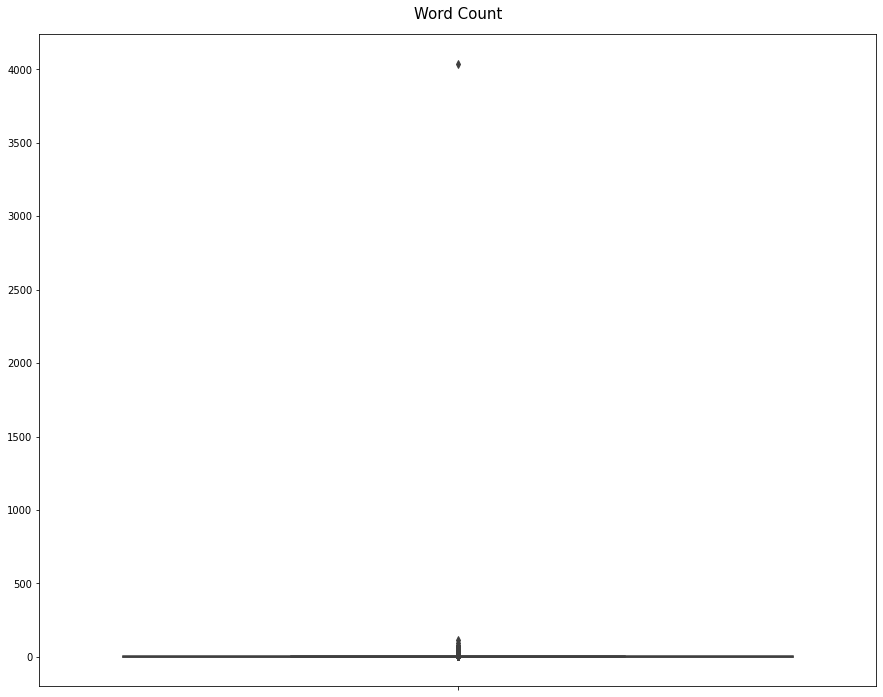

In [76]:


fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts_after_cleaniing, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

# Save New Data

In [78]:
data_dir = os.path.join(os.curdir, "data")
filepath = os.path.join(data_dir, "clean-tweets.tsv")

data.to_csv(path_or_buf=filepath, sep="\t", index=False)